In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as p
import PIL as pil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical,normalize
from sklearn.model_selection import train_test_split
import cv2
from keras import regularizers
import seaborn as sns
%matplotlib inline
import seaborn as sns
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
base= "/kaggle/input/skin-cancer-mnist-ham10000"

In [7]:
metadata=pd.read_csv(os.path.join(base,"C:/Users/Dell/OneDrive/Desktop/Dataset/HAM10000_metadata.csv"))
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [8]:
#To analyse basics of Dataset we study first 5 rows of HAAM10000 Dataset
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
#Checking for NA
metadata.isna().isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [10]:
metadata.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


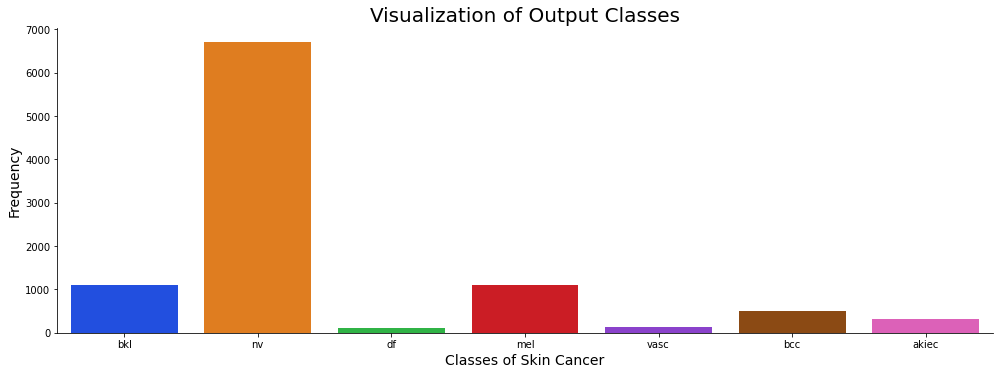

In [11]:

# We need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="dx", kind="count", palette='bright', data=metadata)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Visualization of Output Classes', fontsize=20)
g.set_xlabels('Classes of Skin Cancer', fontsize=14)
g.set_ylabels('Frequency', fontsize=14)

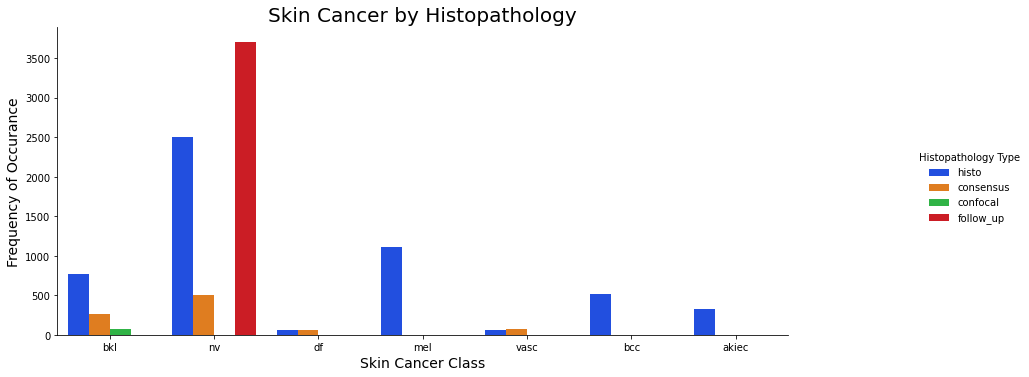

In [12]:
#Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="dx", kind="count", hue="dx_type", palette='bright', data=metadata)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Histopathology Type')

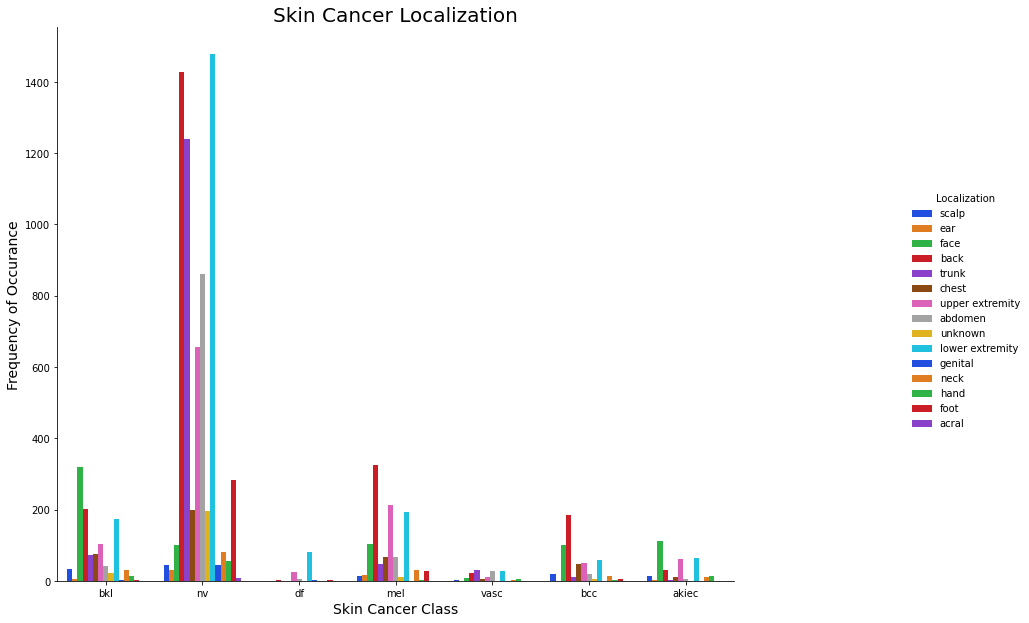

In [13]:
# Skin Cancer occurence body localization
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')

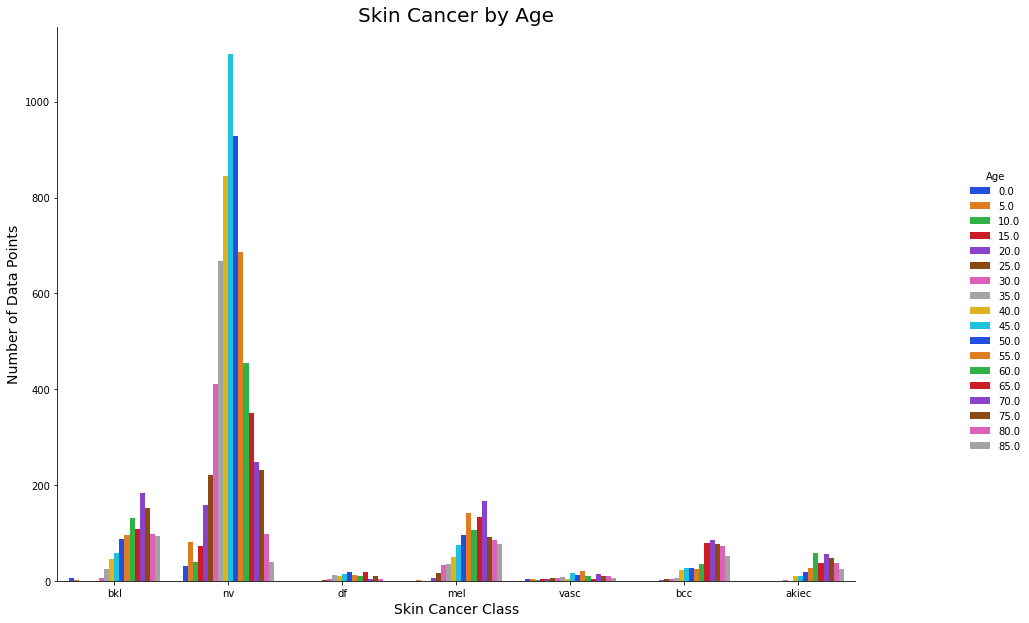

In [14]:
# Skin Cancer occurence by Age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')

In [16]:
df=pd.read_csv(os.path.join(base,"C:/Users/Dell/OneDrive/Desktop/Dataset/hmnist_28_28_RGB.csv"))
x=df.drop('label',axis=1)
y=df['label']
x=x.to_numpy()
x=x/255
y=to_categorical(y)

In [17]:
#Since there are 7 classes only, we can label them manually 
label={
    ' Actinic keratoses':0,
    'Basal cell carcinoma':1,
    'Benign keratosis-like lesions':2,
    'Dermatofibroma':3,
    'Melanocytic nevi':4,
    'Melanoma':6,
    'Vascular lesions':5
}

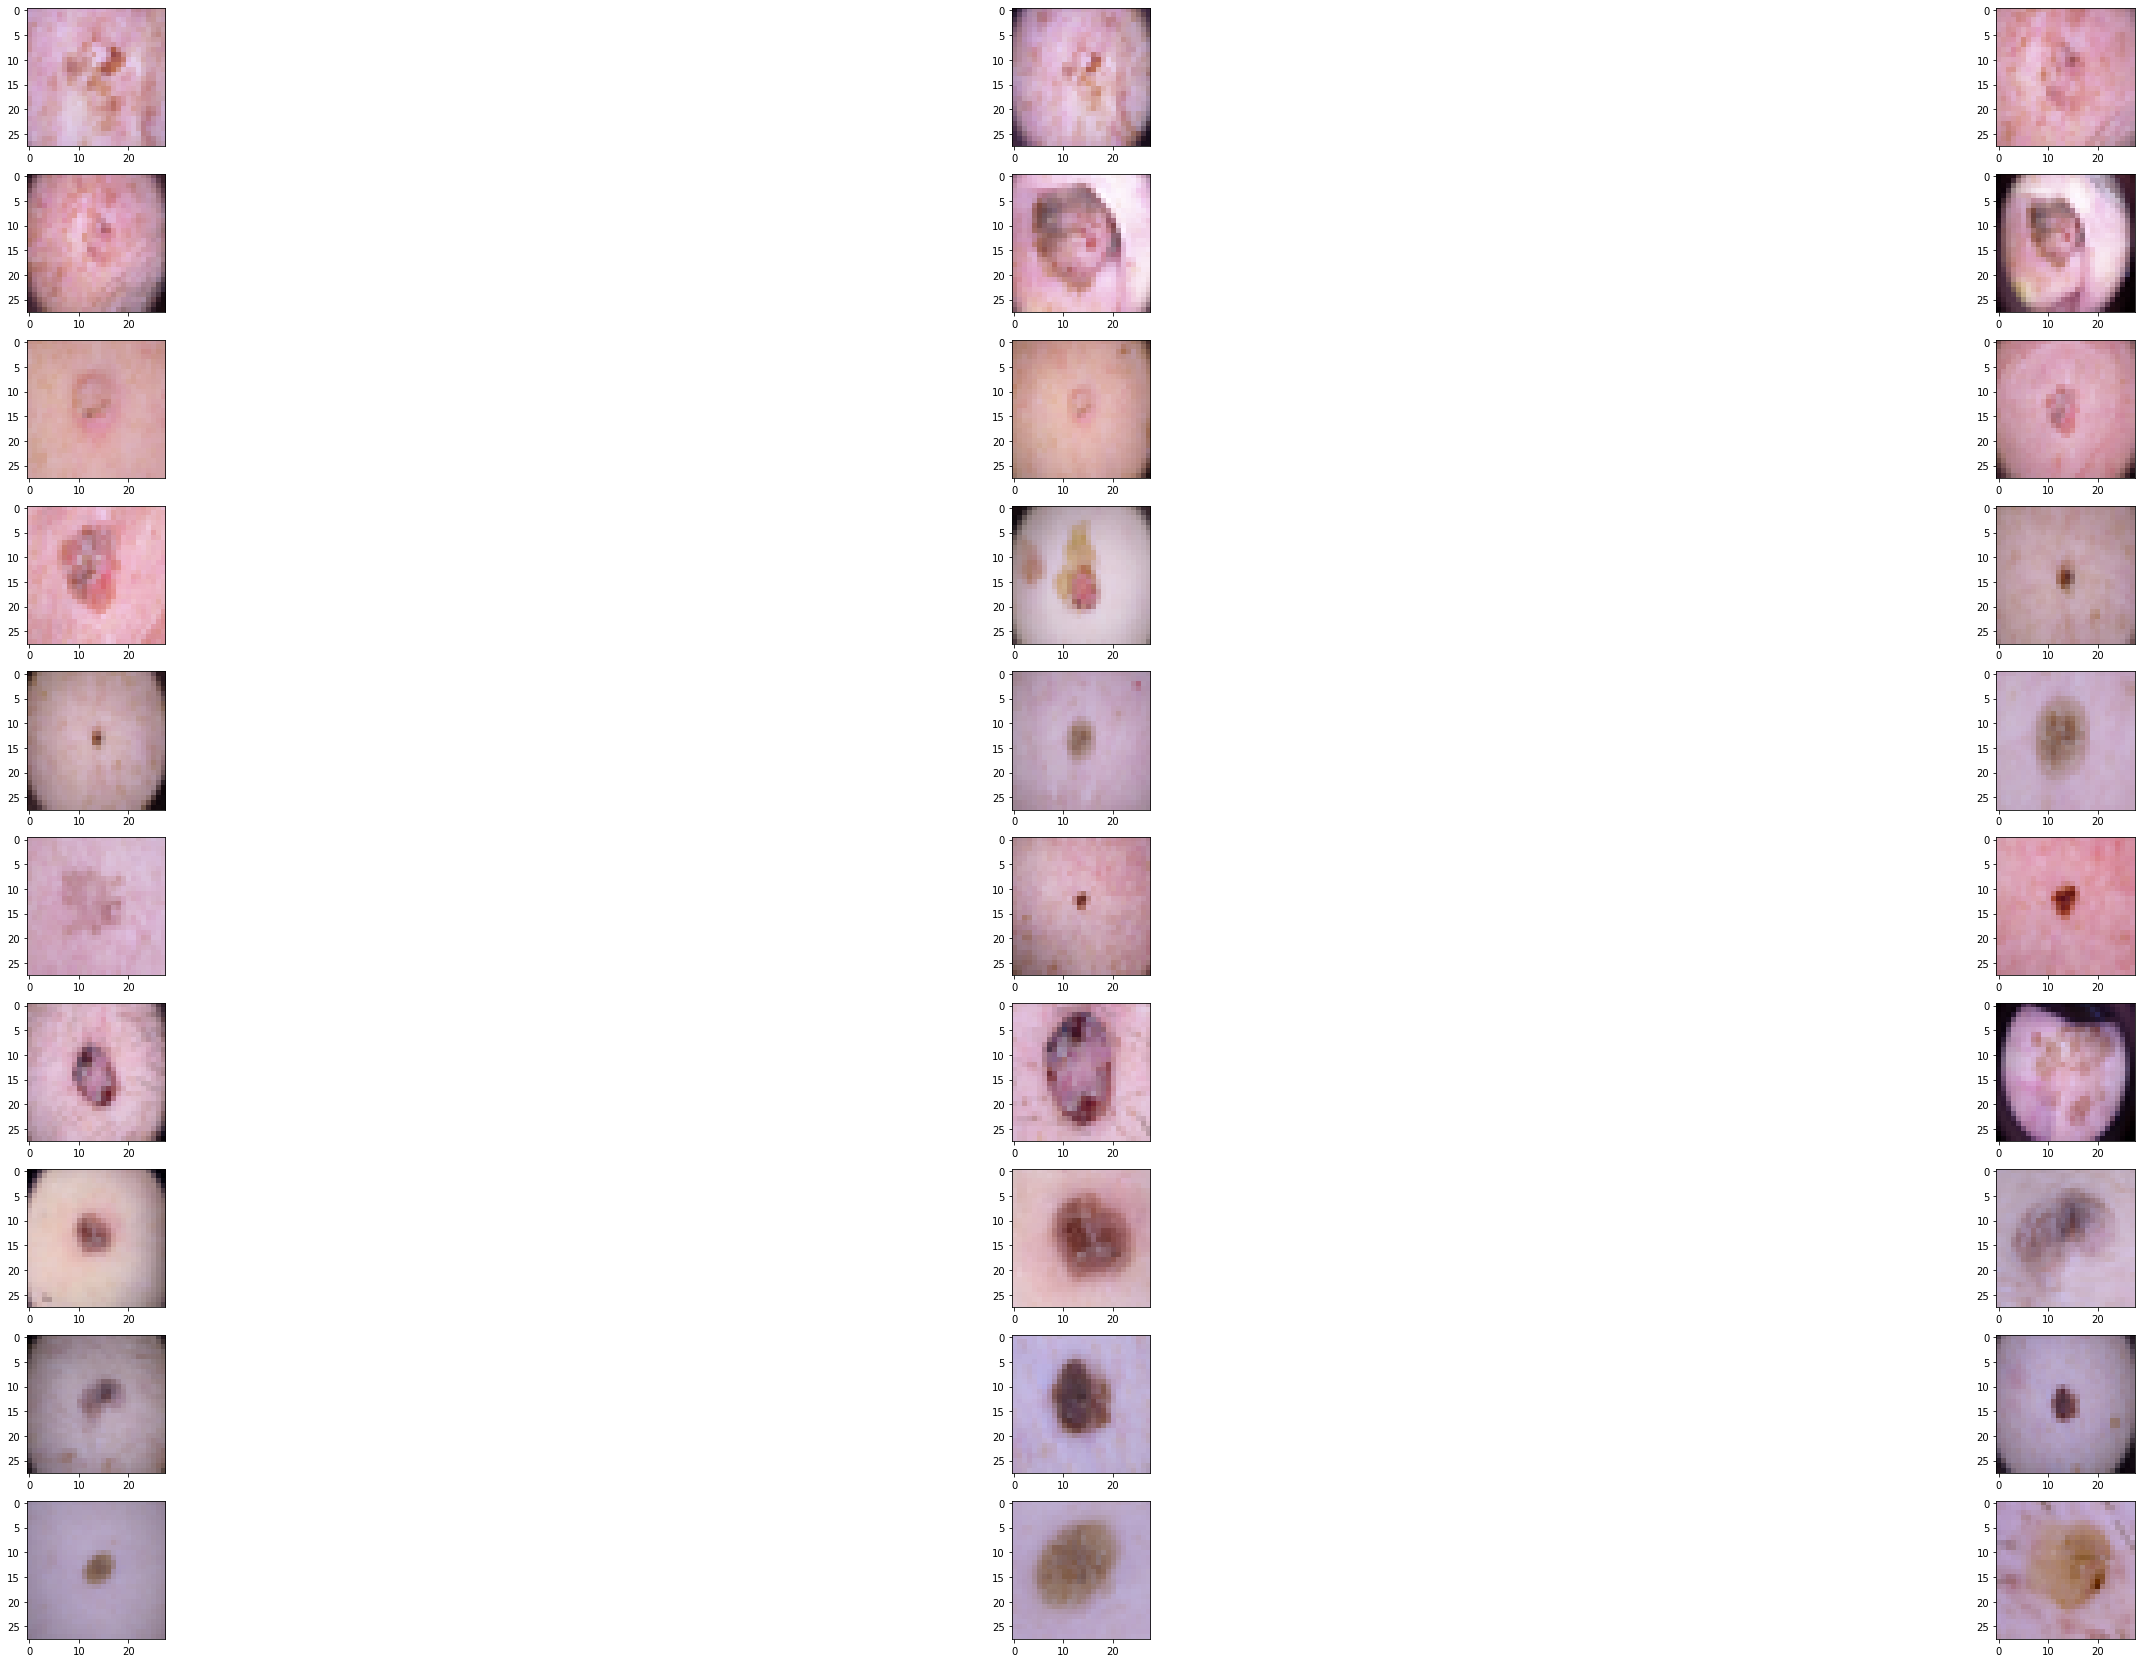

In [18]:
x=x.reshape(-1,28,28,3)
p.figure(figsize=(50,30))
for i in range(30):
    p.subplot(10,3,i+1)
    img=x[i]
    p.imshow(img)

In [19]:
trainx,trainy,testx,testy = train_test_split(x,y,test_size=0.05,random_state=42)

In [20]:
data_generator=ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

In [21]:
data_generator.fit(trainx)

In [22]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
def accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [23]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop

model=Sequential()

model.add(Conv2D(64,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Conv2D(1024,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Conv2D(1024,(1,1),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(BatchNormalization())
#
model.add(Dropout(0.3))
model.add(Conv2D(1024,(1,1),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(BatchNormalization())

#
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(7,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[accuracy])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 512)       131584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 512)        0         
 2D)                                                             
                                                        

In [24]:
#Reviewing our CNN model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 512)       131584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 512)        0         
 2D)                                                             
                                                        

In [25]:
early=EarlyStopping(monitor='accuracy',patience=4,mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=2, verbose=1,cooldown=0, mode='auto',min_delta=0.0001, min_lr=0)

In [26]:
#Training our CNN
class_weights = {0:1,1:0.5,2:1,3:1,4:1,5:1,6:1}
model.fit(trainx,testx,epochs=50,batch_size=90,class_weight=class_weights,validation_data=(trainy, testy),callbacks=[early,reduce_lr])

Epoch 1/50
106/106 [==============================] - 167s 2s/step - loss: 1.1117 - accuracy: 0.7995 - val_loss: 3.2117 - val_accuracy: 0.1796 - lr: 0.0010
Epoch 2/50
106/106 [==============================] - 138s 1s/step - loss: 0.8044 - accuracy: 0.8430 - val_loss: 3.7365 - val_accuracy: 0.1617 - lr: 0.0010
Epoch 3/50
106/106 [==============================] - 121s 1s/step - loss: 0.7431 - accuracy: 0.8560 - val_loss: 2.9472 - val_accuracy: 0.1617 - lr: 0.0010
Epoch 4/50
106/106 [==============================] - 125s 1s/step - loss: 0.6978 - accuracy: 0.8618 - val_loss: 2.2330 - val_accuracy: 0.2774 - lr: 0.0010
Epoch 5/50
106/106 [==============================] - 130s 1s/step - loss: 0.6706 - accuracy: 0.8737 - val_loss: 1.2494 - val_accuracy: 0.7545 - lr: 0.0010
Epoch 6/50
106/106 [==============================] - 120s 1s/step - loss: 0.6629 - accuracy: 0.8728 - val_loss: 1.1439 - val_accuracy: 0.7325 - lr: 0.0010
Epoch 7/50
106/106 [==============================] - 123s 1s/st

<AxesSubplot:>

<Figure size 1080x360 with 0 Axes>

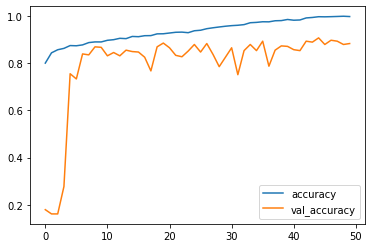

In [27]:
#Visualizing Training and Validation Accuracy
p.figure(figsize=(15,5))
loss=pd.DataFrame(model.history.history)
loss=loss[['accuracy','val_accuracy']]
loss.plot()

In [54]:
model.save('modelv1.h5')